In [ ]:
# !pip install geemap

# Cultivation monitoring using Sentinel 2

In [1]:
import ee
import geemap
import datetime

import pandas as pd
import numpy as np
import plotly.express as px

In [5]:
ee.Initialize()

## 1. Spatial plot of Sentinel 1 data for the selected date range

In [6]:
# Area of interest. Defined by a polygon

# # Define the polygon geometry
# geometry = ee.Geometry.Polygon([[90.87974051393725, 24.027515849512838],
#                                  [90.88031987108447, 24.027515849512838],
#                                  [90.88031987108447, 24.027927414524406],
#                                  [90.87974051393725, 24.027927414524406],
#                                  [90.87974051393725, 24.027515849512838]])


# # AWD in day 3 site. apply water every 6 days
# geometry = ee.Geometry.Polygon([
#   [89.00239529326589, 23.363047351642273],
#   [89.00177838519247, 23.363022728677635],
#   [89.001874944717, 23.362623836013544],
#   [89.00238456442983, 23.362658308266433],
#   [89.00239529326589, 23.363047351642273]
# ]);

# CF in day 3 site. apply water every 2 days
geometry = ee.Geometry.Polygon([
  [89.00103809550436, 23.362348057667866],
  [89.0011185617748, 23.362032881713567],
  [89.00181057170064, 23.362141223532323],
  [89.00177302077444, 23.362451474614677],
  [89.00115611270101, 23.36237268075776],
  [89.00103809550436, 23.362348057667866]
]);

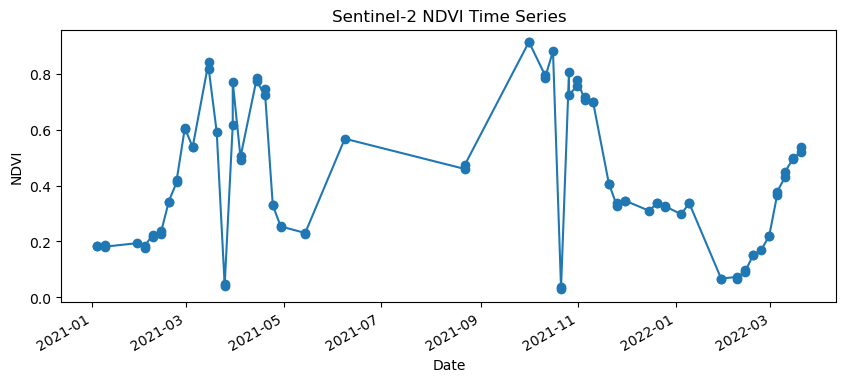

In [14]:
# Define start and end dates
start_date = '2021-01-01'
end_date = '2022-03-30'

# Import the Sentinel-2 dataset
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Filter the Sentinel-2 dataset by date range and AOI
filteredSentinel2 = sentinel2.filterBounds(geometry)\
                             .filterDate(start_date, end_date)\
                             .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)

# Compute the NDVI
def computeNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

ndviCollection = filteredSentinel2.map(computeNDVI)

# Create a function to extract NDVI time series
def createNDVITimeSeries(image):
    reduced = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, reduced).set('system:time_start', image.get('system:time_start'))

# Extract NDVI time series
timeSeries = ndviCollection.map(createNDVITimeSeries)

# Convert the time series to a list
timeSeriesList = timeSeries.getInfo()['features']

# Extract the NDVI values and dates
ndvi_values = [item['properties']['NDVI'] for item in timeSeriesList]
dates = [item['properties']['system:time_start'] for item in timeSeriesList]

# Create a pandas dataframe to plot the time series
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data={"Date": pd.to_datetime(dates, unit='ms'), "NDVI": ndvi_values})
df.set_index("Date", inplace=True)

# Plot the time series
plt.figure(figsize=(10, 4))
df["NDVI"].plot(marker="o", linestyle="-")
plt.title("Sentinel-2 NDVI Time Series")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.show()

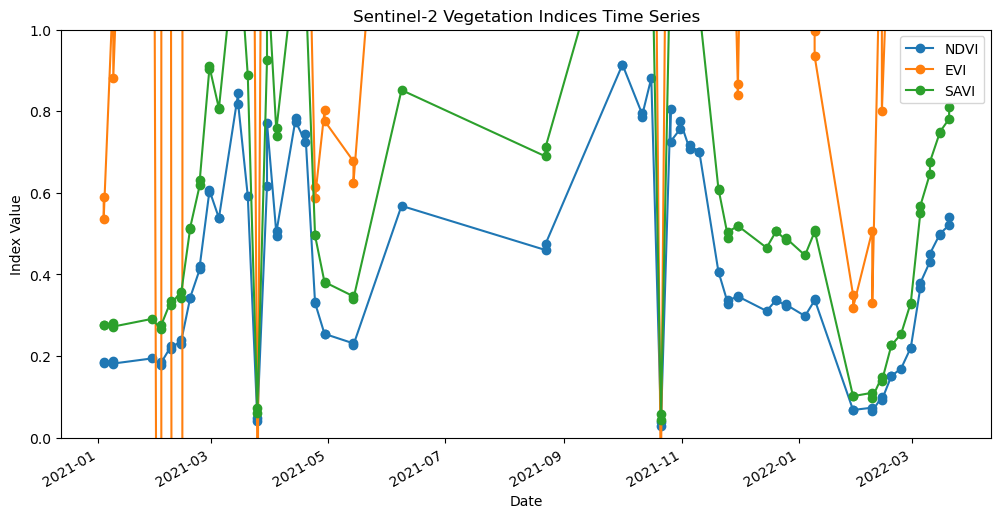

In [15]:
# Compute the EVI
def computeEVI(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands(evi)

# Compute the SAVI
def computeSAVI(image):
    savi = image.expression(
        '((NIR - RED) * (1 + L)) / (NIR + RED + L)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'L': 0.5  # Soil brightness correction factor, set between 0 and 1
        }).rename('SAVI')
    return image.addBands(savi)

# Compute NDVI, EVI, and SAVI
vi_collection = filteredSentinel2.map(computeNDVI).map(computeEVI).map(computeSAVI)

# Create a function to extract the vegetation indices time series
def createTimeSeries(image):
    reduced = image.select(['NDVI', 'EVI', 'SAVI']).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, reduced).set('system:time_start', image.get('system:time_start'))

# Extract the time series
time_series = vi_collection.map(createTimeSeries)

# Convert the time series to a list
time_series_list = time_series.getInfo()['features']

# Extract the index values and dates
ndvi_values = [item['properties']['NDVI'] for item in time_series_list]
evi_values = [item['properties']['EVI'] for item in time_series_list]
savi_values = [item['properties']['SAVI'] for item in time_series_list]
dates = [item['properties']['system:time_start'] for item in time_series_list]

# Create a pandas dataframe to plot the time series
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data={
    "Date": pd.to_datetime(dates, unit='ms'),
    "NDVI": ndvi_values,
    "EVI": evi_values,
    "SAVI": savi_values
})
df.set_index("Date", inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
df.plot(marker="o", linestyle="-", ax=plt.gca())
plt.title("Sentinel-2 Vegetation Indices Time Series")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend(["NDVI", "EVI", "SAVI"])
plt.ylim(0,1)
plt.show()
